In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch

from common.models import simple_conv
import numpy as np



c:\Users\Zumo\anaconda3\envs\torch-gpu\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Zumo\anaconda3\envs\torch-gpu\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\Zumo\anaconda3\envs\torch-gpu\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
bs = 4
tl = 1024
in_feats = 460
base_width = 128
down_layers = 3
dev = torch.device("cuda")

encoder = simple_conv.Encoder(in_feats, down_layers, base_width, [False, True, True])

# model = simple_conv.SimpleSegConv(encoder, 64)
model = simple_conv.SimpleConv(encoder, 64, 1024).to(dev)


In [4]:
ins = torch.randn(bs, tl, in_feats, device=dev)
ins.size()

torch.Size([4, 1024, 460])

In [43]:
_res = []
for _ in range(1000):
    _res.extend(model(ins).cpu().detach().numpy())
res = np.concatenate(_res)
res_t = torch.as_tensor(res)

In [44]:
res.shape, res_t.size()

((4096000, 64), torch.Size([4096000, 64]))

In [14]:
from sklearn.neighbors import KernelDensity

n, d = res.shape
h = (n * (d + 2) / 4.)**(-1. / (d + 4))

kde = KernelDensity(kernel="gaussian", bandwidth=h)

In [46]:
kde.fit(res)

KernelDensity(bandwidth=0.7935259235952904)

In [45]:
from common.kde import KernelDensityEstimator, GaussianKernel

kde2 = KernelDensityEstimator(res_t, GaussianKernel(h), dev)

In [52]:
kde.score_samples(res[:100])

In [48]:
kde2.score_samples(res_t[:10])

RuntimeError: CUDA out of memory. Tried to allocate 9.77 GiB (GPU 0; 6.00 GiB total capacity; 3.54 GiB already allocated; 736.52 MiB free; 3.56 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [51]:
kde2.kernel(res_t[:100], res_t)

RuntimeError: [enforce fail at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\core\impl\alloc_cpu.cpp:81] data. DefaultCPUAllocator: not enough memory: you tried to allocate 104857600000 bytes.

In [49]:
def test(test_data: torch.Tensor, train_data: torch.Tensor) -> None:
    """Computes difference between each x in test_data with all train_data."""

    z = kde2.kernel._get_z(train_data)
    print(z)
    train_data = train_data.unsqueeze(0)

    rets = []
    for datum in test_data:
        diffs = datum - train_data
        log_exp = -0.5 * torch.norm(diffs, p=2, dim=-1) ** 2 

        fin = torch.logsumexp(log_exp - z, dim=-1)
        rets.append(fin.item())
    
    rets_t = torch.as_tensor(rets)
    print(rets_t.size())

In [50]:
test(res_t[:10].to(dev), res_t.to(dev))

tensor(59.2364, device='cuda:0')


RuntimeError: CUDA out of memory. Tried to allocate 1000.00 MiB (GPU 0; 6.00 GiB total capacity; 4.52 GiB already allocated; 0 bytes free; 4.53 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [23]:
from common import data
from typing import Any, Dict
from torch.utils.data import Dataset, DataLoader

paths = data.get_dataset_paths("../data")


In [24]:
dataset = data.Marconi100Dataset(paths)

Loading: 100%|██████████| 249/249 [00:28<00:00,  8.62it/s]


In [28]:
def dataset_iter(dataset):
    for i in range(len(dataset)):
        yield dataset[i]

In [30]:
paths = []
lens = []
anomal = []
for path, data, label in dataset_iter(dataset):
    paths.append(path)
    lens.append(len(label))
    anomal.append(label.sum())
    

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("ggplot")

In [36]:
perc_anomal = np.array(anomal) / np.array(lens)

<AxesSubplot:ylabel='Count'>

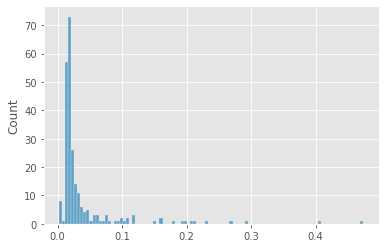

In [37]:
sns.histplot(perc_anomal)

In [38]:
np.mean(perc_anomal)

0.0382103033696152

In [42]:
targ = np.mean(perc_anomal)
tol = 0.005

for path, perc in zip(paths, perc_anomal):
    if targ - tol < perc < targ + tol:
        print(path, perc)

../data\r207n19.gzip 0.033817795108117686
../data\r210n04.gzip 0.04226836070653858
../data\r213n03.gzip 0.034657147106946305
../data\r213n12.gzip 0.03403764886669228
../data\r216n09.gzip 0.037649499633878446
../data\r229n10.gzip 0.04214819850441876
../data\r233n14.gzip 0.03659646385855434
../data\r240n08.gzip 0.034047226798462386
../data\r245n15.gzip 0.040406077719510554
../data\r245n18.gzip 0.03678109674543023
../data\r248n01.gzip 0.03707493702770781
../data\r250n06.gzip 0.036708199656793256
../data\r256n18.gzip 0.03864461981711136
